In [2]:
import cv2
from pvlib import pvsystem, singlediode
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

from scipy.constants import e as qe, k as kB

In [3]:
# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

cell_parameters = {
    'I_L_ref': 18,
    'I_o_ref': 5.16e-9,
    'R_sh_ref': 1000,
      'a_ref': 1.3*Vth,
  'R_s': 0.00181,
    'alpha_sc': 0.0042,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

In [4]:
def plot_curves(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 10])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('Strom [A]')
    axes[0].set_xlabel('Spannung [V]')
    axes[1].set_xlabel('Spannung [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

In [5]:
def plot_curves_test(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(figsize=(5, 5))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes)
        #df.plot('v', 'i', label=label, ax=axes[1])
        axes.set_xlim([0, df['v'].max()*1.5])
        axes.set_ylim([0, 20])
        #axes[1].set_xlim([0, df['v'].max()*1.5])
    axes.set_ylabel('Strom [A]')
    axes.set_xlabel('Spannung [V]')
    #axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

In [6]:
def plot_curves_power(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(figsize=(5, 5))
    for df, label in zip(dfs, labels):
        df.plot('v', 'p', label=label, ax=axes)
        #df.plot('v', 'i', label=label, ax=axes[1])
        axes.set_xlim([0, df['v'].max()*1.5])
        axes.set_ylim([0, 750])
        #axes[1].set_xlim([0, df['v'].max()*1.5])
    axes.set_ylabel('Leistung [W]')
    axes.set_xlabel('Spannung [V]')
    #axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

In [7]:
def simulate_full_curves(parameters, Geffs, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    curves = []
    for Geff in Geffs:
        sde_args = pvsystem.calcparams_desoto(
            Geff,
            Tcell,
            alpha_sc=parameters['alpha_sc'],
            a_ref=parameters['a_ref'],
            I_L_ref=parameters['I_L_ref'],
            I_o_ref=parameters['I_o_ref'],
            R_sh_ref=parameters['R_sh_ref'],
            R_s=parameters['R_s'],
        )
        # sde_args has values:
        # (photocurrent, saturation_current, resistance_series,
        # resistance_shunt, nNsVth)

        # Use Bishop's method to calculate points on the IV curve with V ranging
        # from the reverse breakdown voltage to open circuit
        kwargs = {
            'breakdown_factor': parameters['breakdown_factor'],
            'breakdown_exp': parameters['breakdown_exp'],
            'breakdown_voltage': parameters['breakdown_voltage'],
        }
        v_oc = singlediode.bishop88_v_from_i(
            0.0, *sde_args, **kwargs
        )
        # ideally would use some intelligent log-spacing to concentrate points
        # around the forward- and reverse-bias knees, but this is good enough:
        vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

        ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
        curves.append(pd.DataFrame({
            'i': ivcurve_i,
            'v': ivcurve_v,
        }))
    
    return curves

In [8]:
# https://www.microsemi.com/document-portal/doc_view/125066-rf01055-datasheet

def bypass_diode():
    i_s = 0.00012
    t = 273.15 + 25
    v = np.linspace(0,1,1000)

    n = 1.446554

    v_t = kB * t / qe

    i = i_s * (np.exp(v/(v_t * n)) - 1)
    return pd.DataFrame({'i': i, 'v': -v})

In [9]:
def interpolate_v(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)

In [10]:
def interpolate_i(df, v):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['v']), np.flipud(df['i']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(v)

In [11]:
def assemble_serial(curves):
    i_min = 0
    i_max = 0

    for curve in curves:
        i_min = min(i_min, curve['i'].min())
        i_max = max(i_min, curve['i'].max())

    i_max = min(i_max, 50)

    i = np.linspace(i_min, i_max, 1000)

    v = 0
    
    for curve in curves:
        v_diode = interpolate_v(curve, i)
        v += v_diode
    return pd.DataFrame({'i': i, 'v': v})

In [12]:
def assemble_parallel(curves):
    v_min = 0
    v_max = 0

    for curve in curves:
        v_min = min(v_min, curve['v'].min())
        v_max = max(v_max, curve['v'].max())

    v = np.linspace(v_min, v_max, 1000)

    i = 0
    
    for curve in curves:
        i_diode = interpolate_i(curve, v)
        i += i_diode
    
    return pd.DataFrame({'i': i, 'v': v})

In [13]:
def arr_to_module(arr):
    rotated = np.flip(np.rot90(arr), axis=0)
    combined = np.concatenate((arr[::2], np.flip(arr[1::2], axis=1)), axis=1)
    return combined

In [14]:
def addPower(iv):
    i = iv['i']
    v = iv['v']
    p = v * i
    return pd.DataFrame({'i': i, 'v': v, 'p': p})

In [15]:
def simulate_module_shaded(shadow_arr, poa_direct=800, poa_diffuse=200, Tcell=25, diode_every_cell=False):
    
    shadow_module = arr_to_module(shadow_arr)

    iv_strings = []
    if diode_every_cell:
        for string in shadow_module:
            cell_curves = []
            for curve in simulate_full_curves(cell_parameters, string * poa_direct + poa_diffuse, Tcell):
                cell_curves.append(assemble_parallel([curve, bypass_diode()]))
            iv_strings.append(assemble_serial(cell_curves))

    else:
        for string in shadow_module:
            iv_strings.append(assemble_parallel([assemble_serial(simulate_full_curves(cell_parameters, string * poa_direct + poa_diffuse, Tcell)), bypass_diode()]))

    iv_module = assemble_serial(iv_strings)
    return addPower(iv_module)

In [16]:
def partial_shadow(sun_radius):
    arr = np.linspace(0, 2, sun_radius * 2 + 1)
    arr = np.delete(arr + (arr[1] - arr[0]) / 2, -1)
    shadow_arr = (np.arccos(1 - arr) - (1 - arr) * np.sqrt(2 * arr - arr ** 2)) / np.pi

    return shadow_arr

In [17]:
def solar_cell_mask(cell_size, distance, pix_deg, sun_radius):
    cell_x = cell_size[0]
    cell_y = cell_size[1]

    projection_x = int(2 * math.degrees(math.atan(cell_x / distance / 2)) * pix_deg)
    projection_y = int(2 * math.degrees(math.atan(cell_y / distance / 2)) * pix_deg)
    projection = [projection_x, projection_y]
    
    size_x = projection_x + 2 * sun_radius
    size_y = projection_y + 2 * sun_radius

    mask = np.ones((size_x, size_y))

    shadow_arr = partial_shadow(sun_radius)

    mask[0:sun_radius * 2, :] *= shadow_arr[:, None] # top
    mask[-sun_radius * 2:,:] *= np.flip(shadow_arr)[:, None] # bottom
    mask[:, 0:sun_radius * 2] *= shadow_arr[None, :] # left
    mask[:,-sun_radius * 2:] *= np.flip(shadow_arr)[None, :] # right

    return projection, mask

In [18]:
def get_slices_from_coords(mask, mask_coords):
    res_masks = []
    for row in mask_coords:
        res_row = []
        for cell in row:
            res_row.append(mask[cell[0]:cell[2], cell[1]:cell[3]])
        res_masks.append(res_row)
    return np.array(res_masks)

In [19]:
def solar_module_masks(cell_size, shape, spacing, pos, mask, distance, pix_deg, sun_radius):

    cell_projection, cell_mask = solar_cell_mask(cell_size, distance, pix_deg, sun_radius)
    spacing_projection = np.int_(np.multiply(cell_projection, int(spacing * 1000000)) / cell_size / 1000000)
    unit_projection = cell_projection + spacing_projection

    size = shape * (unit_projection)
    start_pos = pos - size / 2
    cell_mask_size = np.array(cell_mask.shape)

    pos_arr = np.array(np.meshgrid(np.arange(0.5, shape[0] + 0.5), np.arange(0.5, shape[1] + 0.5)))
    pos_arr = pos_arr.T.reshape(shape[0],shape[1],2) * unit_projection + start_pos

    mask_coords = np.int_(np.concatenate((pos_arr - cell_mask_size / 2, pos_arr + cell_mask_size / 2), axis=2))

    tree_mask_slices = get_slices_from_coords(mask, mask_coords) / 255

    combined_masks = tree_mask_slices * cell_mask

    radiation_on_cells = (np.apply_over_axes(np.sum, combined_masks, [2,3]) / np.sum(cell_mask)).reshape(len(combined_masks),-1)

    return radiation_on_cells, combined_masks, cell_mask, mask_coords

In [20]:
def visualize(mask, cell_mask, mask_coords, alpha):
    beta = 1 - alpha

    overlay = np.zeros_like(mask, dtype=float)
    for row in mask_coords:
        for coord in row:
            overlay[coord[0]:coord[2], coord[1]:coord[3]] += cell_mask
    
    vis = cv2.addWeighted(np.float64(mask), alpha, (overlay * 255), beta, 0.0)
    
    return vis


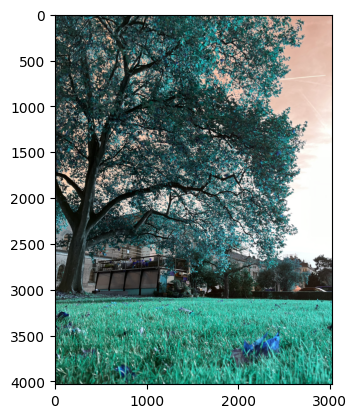

In [21]:
filename = input("Filename: ")
tree_img = cv2.imread('measuredTrees/' + filename)
plt.imshow(tree_img)

In [22]:
distance = 5
pos_az = 10

variation = 200

sun_radius_deg = 0.533

res_x = tree_img.shape[1]
res_y = tree_img.shape[0]
pix_deg = res_x / 65

sun_radius = int(sun_radius_deg * pix_deg) // 2

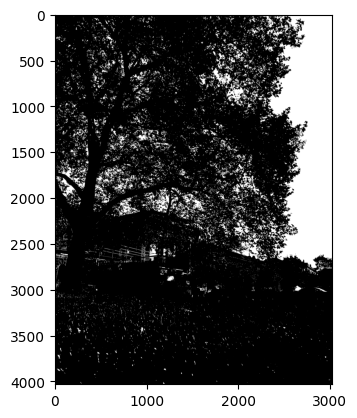

In [23]:
lower_bound = np.array([170, 0, 0])
upper_bound = np.array([360, 255, 255])

mask = cv2.inRange(tree_img, lower_bound, upper_bound)

#cv2.imshow('treemask', imagemask)
plt.imshow(mask, cmap='gray')

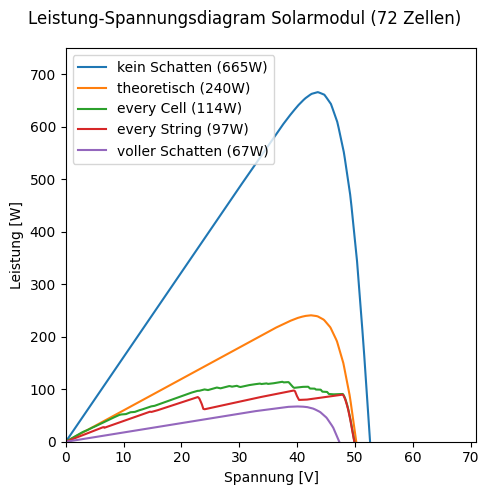

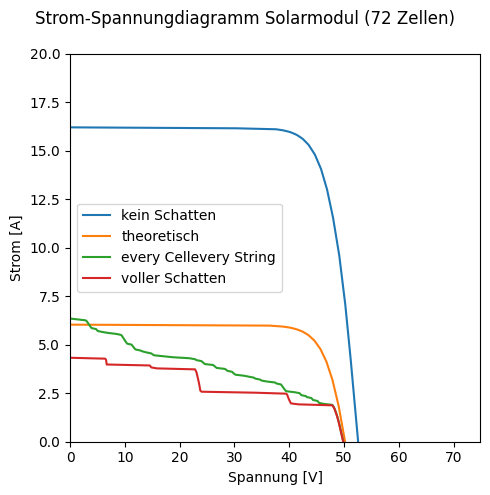

In [31]:
radiation_on_cells1, cells_transmission1, cell_mask1, mask_coords1 = solar_module_masks([0.21, 0.21], [12,6], 0.04, [1550, 900], mask, 14, pix_deg, sun_radius)
radiation_on_cells2, cells_transmission2, cell_mask2, mask_coords2 = solar_module_masks([0.21, 0.21], [12,6], 0.04, [800, 2000], mask, 14, pix_deg, sun_radius)
radiation_on_cells3, cells_transmission3, cell_mask3, mask_coords3 = solar_module_masks([0.21, 0.21], [12,6], 0.04, [750, 900], mask, 14, pix_deg, sun_radius)

radiation_on_cells = radiation_on_cells2

averaged = np.ones_like(radiation_on_cells) * np.average(radiation_on_cells)

iv_module1 = simulate_module_shaded(radiation_on_cells, poa_diffuse=100, diode_every_cell=True)
iv_module2 = simulate_module_shaded(radiation_on_cells, poa_diffuse=100)
iv_module3 = simulate_module_shaded(np.ones_like(radiation_on_cells), poa_diffuse=100)
iv_module4 = simulate_module_shaded(np.zeros_like(radiation_on_cells), poa_diffuse=100)
iv_module5 = simulate_module_shaded(averaged, poa_diffuse=100)

p_max1 = iv_module1['p'].max()
p_max2 = iv_module2['p'].max()
p_max3 = iv_module3['p'].max()
p_max4 = iv_module4['p'].max()
p_max5 = iv_module5['p'].max()


curves = [iv_module3, iv_module5, iv_module1, iv_module2, iv_module4]
labels_p = ['kein Schatten (' + str(int(p_max3)) + 'W)', 'theoretisch (' + str(int(p_max5)) + 'W)', 'every Cell (' + str(int(p_max1)) + 'W)', 'every String (' + str(int(p_max2)) + 'W)', 'voller Schatten (' + str(int(p_max4)) + 'W)']
labels_i = ['kein Schatten', 'theoretisch', 'every Cell' 'every String', 'voller Schatten']

ax = plot_curves_power(curves, labels=labels_p, title='Leistung-Spannungsdiagram Solarmodul (72 Zellen)')
ax = plot_curves_test(curves, labels_i, 'Strom-Spannungdiagramm Solarmodul (72 Zellen)')


In [25]:
radiation_on_cells = radiation_on_cells3

res_table = [["Diffuse Einstahlung [W/m^2]", "voller Schatten [W/m^2]", "Diode für jeden String [W/m^2]", "Diode für jede Zelle [W/m^2]", "direkte Einstahlung jeder String [W/m^2]", "direkte Einstahlung jede Zelle [W/m^2]", "Leistungsanstieg bei jede Zelle"]]
for i, diffuse in enumerate(range(0, 225, 25)): #0-200
    res_row = [diffuse]
    full_shadow = simulate_module_shaded(np.zeros_like(radiation_on_cells), poa_diffuse=diffuse)['p'].max()
    every_string = simulate_module_shaded(radiation_on_cells, poa_diffuse=diffuse)['p'].max()
    every_cell = simulate_module_shaded(radiation_on_cells, poa_diffuse=diffuse, diode_every_cell=True)['p'].max()
    
    direct_every_string = every_string - full_shadow
    direct_every_cell = every_cell - full_shadow

    direct_power_increase = direct_every_cell / direct_every_string - 1

    res_table.append([diffuse, full_shadow, every_string, every_cell, direct_every_string, direct_every_cell, direct_power_increase])

In [27]:
df_table = pd.DataFrame(res_table)

writer = pd.ExcelWriter('test.xlsx')

df_table.to_excel(writer, sheet_name='2', index=False)

writer.save()

C:\Users\patri\AppData\Local\Temp\ipykernel_16616\1808722512.py:7: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


True

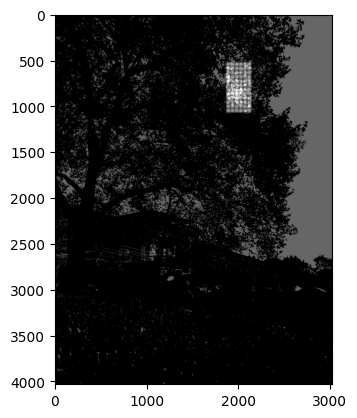

In [28]:
#vis_filename = input('visualisation filename')
#mask_coords = [*mask_coords1, *mask_coords2, *mask_coords3]
vis = visualize(mask, cell_mask2, mask_coords2, 0.4)
plt.imshow(vis, cmap='gray')
#cv2.imwrite('doc_pictures/' + vis_filename + 'png', vis)
cv2.imwrite('test.png', vis)